### progetto information similarity

### librerie

In [1]:
import fitz  # PyMuPDF
import spacy
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import PyPDF2
import os
from PyPDF2 import PdfReader
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from rake_nltk import Rake
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering

### estrazione testo e parole chiave 

In [2]:
def estrai_testo_e_token_da_pdf(file_path):
    try:
        documento = fitz.open(file_path)
        testo = ""
        for pagina in documento:
            testo += pagina.get_text()
        num_token = len(testo.split())
        return testo, num_token
    except Exception as e:
        print(f"Errore nell'estrazione del testo da {file_path}: {e}")
        return "", 0

def estrai_parole_chiave_da_testo(testo, num_token, percentuale=0.02, max_keywords=500):
    try:
        num_keywords = min(int(num_token * percentuale), max_keywords)
        
        r = Rake()
        r.extract_keywords_from_text(testo)
        parole_chiave = r.get_ranked_phrases_with_scores()[:num_keywords]
        
        return [kw[1] for kw in parole_chiave]
    except Exception as e:
        print(f"Errore nell'estrazione delle parole chiave: {e}")
        return []

In [3]:
pdf_files = ["art_1.pdf", "art_2.pdf", "art_3.pdf", "art_4.pdf", "art_5.pdf", "art_6.pdf", "art_7.pdf", "art_8.pdf", "art_9.pdf", "art_10.pdf",
             "art_11.pdf", "art_12.pdf", "art_13.pdf", "art_14.pdf", "art_15.pdf", "art_16.pdf", "art_17.pdf", "art_18.pdf",
             "art_19.pdf", "art_20.pdf", "art_21.pdf", "art_22.pdf", "art_23.pdf", "art_24.pdf", "art_25.pdf", "art_26.pdf", "art_27.pdf",
             "art_28.pdf", "art_29.pdf", "art_30.pdf", "art_31.pdf", "art_32.pdf"] 

In [4]:
testi = {}
parole_chiave_articoli = {}
for file in pdf_files:
    testo, num_token = estrai_testo_e_token_da_pdf(file)
    if testo:
        testi[file] = testo
        parole_chiave = estrai_parole_chiave_da_testo(testo, num_token)
        parole_chiave_articoli[file] = parole_chiave
    else:
        print(f"Nessun testo estratto da {file}")
        
for file, testo in testi.items():
    print(f"Testo estratto da {file}:\n{testo[:500]}...")  # Stampa i primi 500 caratteri per ogni articolo

for file, parole_chiave in parole_chiave_articoli.items():
    print(f"Parole chiave estratte da {file}: {parole_chiave}")

Testo estratto da art_1.pdf:
Citation: Wang, C.; Mahbod, A.;
Ellinger, I.; Galdran, A.;
Gopalakrishnan, S.; Niezgoda, J.; Yu,
Z. FUSeg: The Foot Ulcer
Segmentation Challenge. Information
2024, 15, 140. https://doi.org/
10.3390/info15030140
Academic Editor: Xiaoshuang Shi
Received: 31 January 2024
Revised: 25 February 2024
Accepted: 27 February 2024
Published: 1 March 2024
Copyright: © 2024 by the authors.
Licensee MDPI, Basel, Switzerland.
This article is an open access article
distributed
under
the
terms
and
conditions of ...
Testo estratto da art_2.pdf:
Citation: Hu, H.; Chen, J.; Zhu, J.;
Yang, Y.; Zheng, H. Design and
Development of an Integrated
Virtual-Reality Training Simulation
Sand Table for Rail Systems.
Information 2024, 15, 141. https://
doi.org/10.3390/info15030141
Academic Editor: Andrea Sanna
Received: 29 January 2024
Revised: 28 February 2024
Accepted: 1 March 2024
Published: 5 March 2024
Copyright: © 2024 by the authors.
Licensee MDPI, Basel, Switzerland.
This article 

### modello embedding

In [5]:
modello_embedding = SentenceTransformer('all-MiniLM-L6-v2')

def ottieni_vettori_embedding(parole_chiave, modello_embedding):
    try:
        embedding = np.mean([modello_embedding.encode(kw) for kw in parole_chiave], axis=0)
        return embedding
    except Exception as e:
        print(f"Errore nell'ottenimento dei vettori di embedding: {e}")
        return np.zeros(modello_embedding.get_sentence_embedding_dimension())

# Calcolo degli embedding
embeddings = {}
for file, parole_chiave in parole_chiave_articoli.items():
    embedding = ottieni_vettori_embedding(parole_chiave, modello_embedding)
    embeddings[file] = embedding

# Controlla l'output degli embeddings
for file, embedding in embeddings.items():
    print(f"Embedding per {file}: {embedding[:500]}...")  # Stampa i primi 500 valori del vettore di embedding

if len(embeddings) > 1:
    articoli = list(embeddings.keys())
    vettori = np.array(list(embeddings.values()))

    similarita = cosine_similarity(vettori)

    for i in range(len(articoli)):
        for j in range(i + 1, len(articoli)):
            print(f"Similarità tra {articoli[i]} e {articoli[j]}: {similarita[i][j]:.4f}")
else:
    print("Non ci sono abbastanza articoli per calcolare la similarità.")

Embedding per art_1.pdf: [-2.61710826e-02 -1.74468793e-02  1.39291091e-02  3.12833884e-03
  1.34302434e-02  5.29976841e-03 -3.89218540e-03 -4.59136488e-03
 -2.06022896e-02 -1.64537057e-02 -8.97744484e-03 -1.40459584e-02
 -9.60236823e-04  2.33907662e-02 -5.08061871e-02 -4.06018365e-03
 -1.92333274e-02  1.24543188e-02 -3.60862277e-02 -3.21002081e-02
 -7.47958664e-03 -2.80892034e-03  2.13047885e-03  2.79570883e-03
  2.16042660e-02 -2.89234659e-03  3.92978219e-03 -3.16174864e-03
  1.72659773e-02 -2.69442555e-02  1.56298522e-02  3.01471725e-03
  1.32225873e-02  1.78718399e-02  2.96680699e-03 -2.04037111e-02
 -7.96724577e-03  7.56293070e-03 -1.11657577e-02  1.42366495e-02
 -4.32511140e-03 -3.76922973e-02  1.61185011e-03  1.33290291e-02
  5.09465970e-02  8.12623929e-03 -1.59368943e-02  4.89235669e-03
  9.72313515e-04  2.25846712e-02 -2.52255071e-02 -1.40388431e-02
 -1.26883509e-02  9.92535986e-03  6.64129341e-03 -7.25584431e-03
 -9.94844083e-03 -2.97155697e-02 -7.29830004e-04 -4.82674746e-04


### matrice di similarità

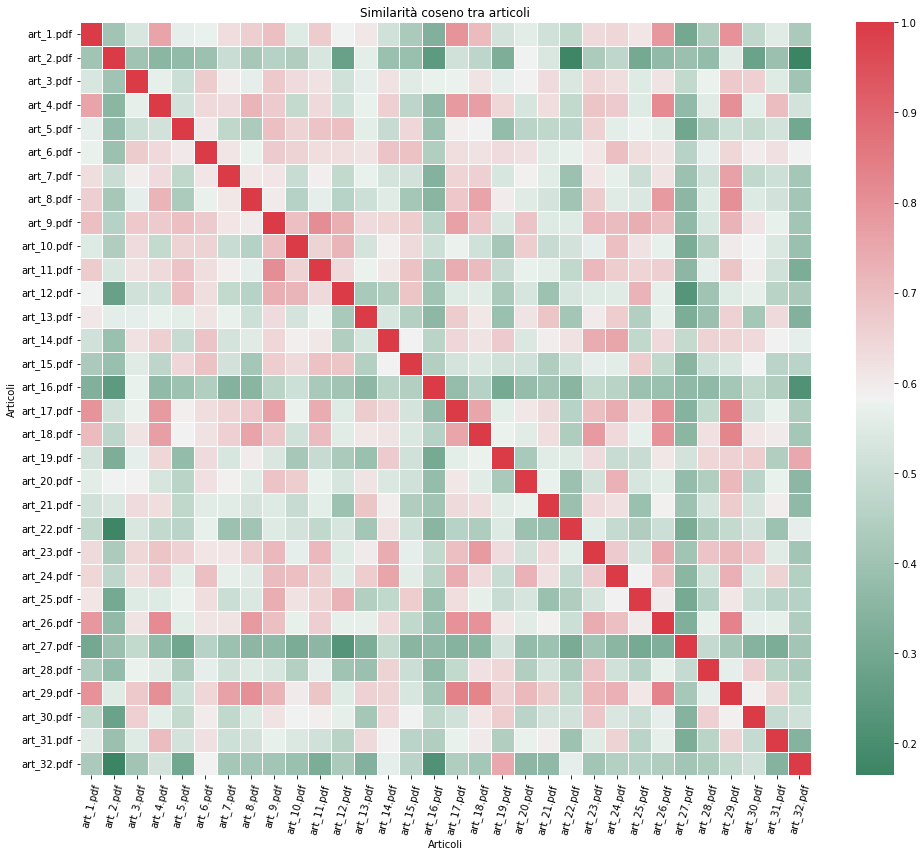

In [6]:
# Calcola la matrice di similarità come hai fatto prima
similarita = cosine_similarity(vettori)

# Crea un dataframe Pandas con la matrice di similarità e gli indici degli articoli
df_similarita = pd.DataFrame(similarita, index=articoli, columns=articoli)

# Trova i valori massimi e minimi della matrice di similarità
vmin = df_similarita.values.min()
vmax = df_similarita.values.max()

# Scala di colore personalizzata
cmap_custom = sns.diverging_palette(150, 10, as_cmap=True)

# Crea il grafico utilizzando i valori massimi e minimi come scala di colore personalizzata
plt.figure(figsize=(14, 12))
sns.heatmap(df_similarita, cmap=cmap_custom, annot=False, linewidths=0.5, linecolor='white', vmin=vmin, vmax=vmax)
plt.title("Similarità coseno tra articoli")
plt.xlabel("Articoli")
plt.ylabel("Articoli")
plt.xticks(rotation=75)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Agglomerative Hierarchical Clustering:

Agglomerative Hierarchical Clustering:


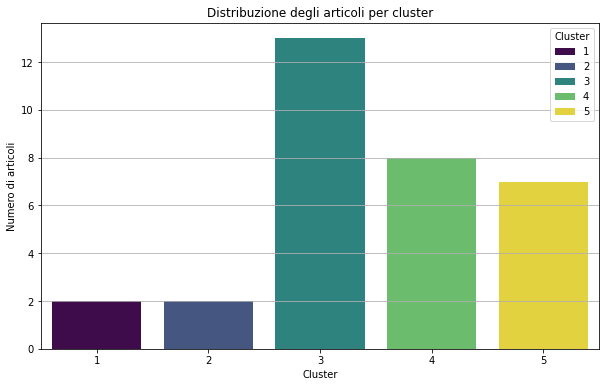

   Cluster  Num_Articoli                                           Articoli
0        1             2                            [art_2.pdf, art_27.pdf]
1        2             2                           [art_19.pdf, art_32.pdf]
2        3            13  [art_3.pdf, art_6.pdf, art_13.pdf, art_14.pdf,...
3        4             8  [art_1.pdf, art_4.pdf, art_7.pdf, art_8.pdf, a...
4        5             7  [art_5.pdf, art_9.pdf, art_10.pdf, art_11.pdf,...


/var/folders/g7/rbg8pg613cjgrsf5zgq01fn00000gn/T/ipykernel_1216/3936763205.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_articles = df_similarita.groupby('Cluster', group_keys=False).apply(lambda x: list(x.index)).reset_index(name='Articoli')


In [8]:
# Inizializza il modello di clustering
n_clusters = 5
clustering = AgglomerativeClustering(n_clusters=n_clusters)

# Fai il clustering sui dati
cluster_labels = clustering.fit_predict(vettori)

# Rinumerazione dei cluster per partire da 1 invece che da 0
cluster_labels_renumbered = cluster_labels + 1

# Aggiungi le etichette dei cluster rinumerate al dataframe
df_similarita['Cluster'] = cluster_labels_renumbered

# Visualizza i cluster trovati
print("Agglomerative Hierarchical Clustering:")

# Plot del mood dei cluster
plt.figure(figsize=(10, 6))
sns.countplot(data=df_similarita, x='Cluster', hue='Cluster', palette='viridis', dodge=False)
plt.title("Distribuzione degli articoli per cluster")
plt.xlabel("Cluster")
plt.ylabel("Numero di articoli")
plt.grid(axis='y')  # Aggiungi solo la griglia orizzontale
plt.show()

# Dettagli dei cluster
cluster_details = df_similarita['Cluster'].value_counts().sort_index()

# Raggruppa gli articoli per cluster
cluster_articles = df_similarita.groupby('Cluster', group_keys=False).apply(lambda x: list(x.index)).reset_index(name='Articoli')

# Crea la tabella dei cluster
cluster_table = pd.DataFrame({'Cluster': cluster_details.index, 'Num_Articoli': cluster_details.values})
cluster_table = cluster_table.merge(cluster_articles, on='Cluster')

print(cluster_table)

# Salva la tabella dei cluster in un file CSV
cluster_table.to_csv('cluster_articoli3.csv', index=False)
